In [1]:
#below classes we used to interact with any llm model
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint

#to convert the simple user query to Prompt we are using Chatprompttemplate,prompttemplate
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate

#parser classes to parser 
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser

#loading the env filter
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
#creating an object of chatGroq class
model1 = ChatGroq(
    model="llama-3.1-8b-instant",temperature=0 #temperature is called creative parameter
)

#creating an object openai model class
model2 = ChatOpenAI(
    model="gpt-3.5-turbo",temperature=0
)

#creating an object open source model.
#HuggingFaceEndpoint is a class where we are sending or hitting user query request to get response
llm = HuggingFaceEndpoint(  
        repo_id="meta-llama/Meta-Llama-3-8B-Instruct",  
        task="text-generation",  
        )  
model3 = ChatHuggingFace(llm=llm)

# statefull or memory define as a workflow schema

In [3]:
from typing import TypedDict

class LearningState(TypedDict):
    graph_state : str


# Nodes in LanGraph sequential workflow defining

In [4]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [5]:
#creating stategraph object.
from langgraph.graph import StateGraph,START,END

builder = StateGraph(state_schema=LearningState)
builder

In [6]:
#now adding to the graph or constructing the Graph.
builder.add_node(node='node_1',action=node_1)
builder.add_node(node='node_2',action=node_2)
builder.add_node(node='node_3',action=node_3)

In [7]:
#now adding edges to the graph object.
builder.add_edge(start_key=START,end_key='node_1')
builder.add_edge(start_key='node_1',end_key='node_2')
builder.add_edge(start_key='node_2',end_key='node_3')
builder.add_edge(start_key='node_3',end_key=END)


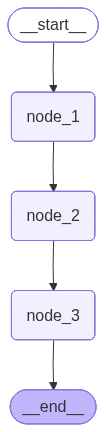

In [8]:
#now compiling the graph
builder.compile()

In [9]:
#complied workflow
wokflow : LearningState = builder.compile()

In [10]:
#passing the initial state or memory to my workflow.
inital_state = LearningState(graph_state='Hi')
inital_state

{'graph_state': 'Hi'}

In [11]:
wokflow.invoke(inital_state)

---Node 1---
---Node 2---
---Node 3---


{'graph_state': 'Hi I am happy! sad!'}

# case:-b)  Now adding LLM to lanGraph Workflow

In [12]:
#creating a stateschema using dataclasses 
from dataclasses import dataclass
from typing import Optional

@dataclass
class FirstLLMAgentState():
    prompt:str
    output:Optional[str] = None

In [13]:
#creating an object of stateGraph
graph = StateGraph(state_schema=FirstLLMAgentState)
graph

In [14]:
from langchain_core.messages.ai import AIMessage

In [15]:
def calling_llm(state:FirstLLMAgentState) ->FirstLLMAgentState:
    parser = StrOutputParser()
    #fetching the user prompt from state class.
    user_prompt = state.prompt
    
    #chain is runnable so we can invoke.
    ai_response :AIMessage = model1.invoke(user_prompt)
    
    
    #updating the partial state.
    return {
        
        "output" : ai_response.content
    }
    

In [16]:
#now adding nodes and edges to graph.
graph.add_node(node="calling_llm",action=calling_llm)

In [17]:
#adding the  edges to worklfow.
graph.add_edge(START,"calling_llm")
graph.add_edge("calling_llm",END)

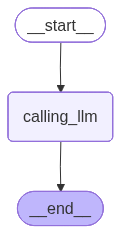

In [18]:
#compiling the graph
graph.compile()

In [19]:
#compiling the worklfow
workflow2 = graph.compile()

In [20]:
#passing the initial state to workflow2.
#syncrously execution graph from top to bottom

initial = FirstLLMAgentState(prompt="Hello how are you")

#passing the initial to my worklfow2 to start node.
response = workflow2.invoke(initial)
response

{'prompt': 'Hello how are you',
 'output': "I'm just a computer program, so I don't have feelings, but I'm functioning properly and ready to help you with any questions or tasks you may have. How can I assist you today?"}

In [21]:
type(response)

dict

# case:c) Making conditional workflow

In [22]:
from typing import TypedDict

class LearningState2(TypedDict):
    graph_state : str


In [23]:
def node__1(state:LearningState2) -> LearningState2:
    print("---Node 1---")
    #partially updating the state.
    return {"graph_state": state['graph_state'] +" I am"}

def node__2(state:LearningState2) -> LearningState2:
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node__3(state:LearningState2) -> LearningState2:
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

# creating router function 

In [24]:
import numpy as np
from typing import Literal
def router_function(state:LearningState2) ->Literal["node__2", "node__3"]:
    user_input = state['graph_state']
    
    if np.random.random() >0.5:
        return "node__3"
    else:
        return "node__2"
    

In [25]:
#creating stategraph object.
from langgraph.graph import StateGraph,START,END

builder2 = StateGraph(state_schema=LearningState2)
builder2

In [26]:
#now adding to the graph or constructing the Graph.
builder2.add_node(node='node__1',action=node__1)
builder2.add_node(node='node__2',action=node__2)
builder2.add_node(node='node__3',action=node__3)


In [27]:
# adding edges to graph.
builder2.add_edge(START,"node__1")
builder2.add_conditional_edges('node__1',router_function)

#adding edges to end.
builder2.add_edge("node__2",END)
builder2.add_edge("node__3",END)

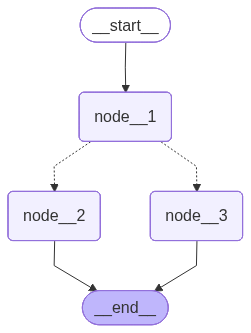

In [28]:
#compiling the workflow
graph2 = builder2.compile()
graph2

In [30]:
#invoking the graph.
graph2.invoke(input=LearningState2(graph_state="hello"))

---Node 1---
---Node 2---


{'graph_state': 'hello I am happy!'}